In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# ## Cell 2: Configuration


RESULTS_DIR = "Results_Mofaflex"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {os.path.abspath(RESULTS_DIR)}")

FEATURE_COUNTS = [2000, 4000, 6000, 10000]
N_FACTORS = 15
RANDOM_STATE = 42
# ## Cell 3: Load Raw Data


print("=" * 70)
print("LOADING RAW DATA")
print("=" * 70)

expression_data = pd.read_csv('../RawData/TCGA-SARC.star_tpm.tsv', sep='\t', index_col=0)
methylation_data = pd.read_csv('../RawData/TCGA-SARC.methylation450.tsv', sep='\t', index_col=0)
copy_number_data = pd.read_csv('../RawData/TCGA-SARC.gene-level_absolute.tsv', sep='\t', index_col=0)

try:
    phenotype_data = pd.read_csv('../RawData/TCGA-SARC.clinical.tsv', sep='\t', index_col=0)
except:
    phenotype_data = pd.read_csv('../RawData/TCGA-SARC.clinical.tsv', sep='\t', index_col=0, on_bad_lines='skip')

print("Data shapes:")
print(f"  Expression: {expression_data.shape}")
print(f"  Methylation: {methylation_data.shape}")
print(f"  Copy Number: {copy_number_data.shape}")
print(f"  Phenotype: {phenotype_data.shape}")

print("=" * 70)
print("SAMPLE MATCHING")
print("=" * 70)

samples_expression = set(expression_data.columns)
samples_methylation = set(methylation_data.columns)
samples_cnv = set(copy_number_data.columns)
samples_clinical = set(phenotype_data.index)

common_samples = list(samples_expression & samples_methylation & samples_cnv & samples_clinical)
print(f"Common samples across all omics: {len(common_samples)}")

expression_data = expression_data[common_samples]
methylation_data = methylation_data[common_samples]
copy_number_data = copy_number_data[common_samples]
phenotype_data = phenotype_data.loc[common_samples]

Using device: cuda
Results will be saved to: f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\src\Results_Mofaflex
LOADING RAW DATA
Data shapes:
  Expression: (60660, 265)
  Methylation: (486427, 269)
  Copy Number: (60623, 248)
  Phenotype: (272, 78)
SAMPLE MATCHING
Common samples across all omics: 246


In [5]:
print("=" * 70)
print("MINIMAL PREPROCESSING (Safe Operations)")
print("=" * 70)

def drop_all_nan_rows(data, name):
    before = data.shape[0]
    all_nan_mask = data.isna().all(axis=1)
    data = data.loc[~all_nan_mask]
    dropped = all_nan_mask.sum()
    print(f"  {name}: {before} -> {data.shape[0]} (dropped {dropped} NaN rows)")
    return data

expression_data = drop_all_nan_rows(expression_data, "Expression")
methylation_data = drop_all_nan_rows(methylation_data, "Methylation")
copy_number_data = drop_all_nan_rows(copy_number_data, "Copy Number")

# Log transformations (safe - no statistics from data)
expression_data_log = np.log2(expression_data + 1)

methylation_data = methylation_data.dropna(thresh=0.8 * methylation_data.shape[1], axis=0)
epsilon = 1e-6
methylation_beta = methylation_data.clip(epsilon, 1 - epsilon)
methylation_m_values = np.log2(methylation_beta / (1 - methylation_beta))

copy_number_filtered = copy_number_data.loc[copy_number_data.isnull().mean(axis=1) < 0.2]
cnv_clipped = copy_number_filtered.clip(lower=0.05, upper=6)
cnv_log = np.log2(cnv_clipped / 2)

print(f"\nAfter log transforms:")
print(f"  Expression: {expression_data_log.shape}")
print(f"  Methylation: {methylation_m_values.shape}")
print(f"  Copy Number: {cnv_log.shape}")

# Cell 6: Phenotype Processing and Label Encoding

print("=" * 70)
print("PHENOTYPE PROCESSING")
print("=" * 70)

subtype_column = 'primary_diagnosis.diagnoses'
selected_subtypes = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma',
    'Fibromyxosarcoma'
]

phenotype_data = phenotype_data[phenotype_data[subtype_column].isin(selected_subtypes)]
phenotype_data_clean = phenotype_data.dropna(subset=[subtype_column])

subtypes = phenotype_data_clean[subtype_column]
label_encoder = LabelEncoder()
subtype_encoded = pd.Series(
    label_encoder.fit_transform(subtypes),
    index=subtypes.index,
    name='subtype_encoded'
)

print("Label encoding:")
for i, cls in enumerate(label_encoder.classes_):
    count = (subtype_encoded == i).sum()
    print(f"  {i}: {cls} ({count} samples)")

# Update common samples
valid_samples = list(set(common_samples) & set(phenotype_data_clean.index))
expression_data_log = expression_data_log[valid_samples]
methylation_m_values = methylation_m_values[valid_samples]
cnv_log = cnv_log[valid_samples]
subtype_encoded = subtype_encoded.loc[valid_samples]
common_samples = valid_samples

print(f"\nFinal sample count: {len(common_samples)}")

MINIMAL PREPROCESSING (Safe Operations)
  Expression: 60660 -> 60660 (dropped 0 NaN rows)
  Methylation: 486427 -> 421599 (dropped 64828 NaN rows)
  Copy Number: 60623 -> 57240 (dropped 3383 NaN rows)

After log transforms:
  Expression: (60660, 246)
  Methylation: (396650, 246)
  Copy Number: (56756, 246)
PHENOTYPE PROCESSING
Label encoding:
  0: Dedifferentiated liposarcoma (53 samples)
  1: Fibromyxosarcoma (22 samples)
  2: Leiomyosarcoma, NOS (96 samples)
  3: Undifferentiated sarcoma (34 samples)

Final sample count: 205


In [6]:
print("=" * 70)
print("EXTRACTING SURVIVAL DATA")
print("=" * 70)

# Common survival columns in TCGA
survival_time_cols = ['days_to_death.demographic', 'days_to_last_follow_up.diagnoses', 
                       'days_to_death', 'days_to_last_followup', 'OS.time']
vital_status_cols = ['vital_status.demographic', 'vital_status', 'OS']

# Find available columns
time_col = None
status_col = None

for col in survival_time_cols:
    if col in phenotype_data_clean.columns:
        time_col = col
        print(f"Found survival time column: {col}")
        break

for col in vital_status_cols:
    if col in phenotype_data_clean.columns:
        status_col = col
        print(f"Found vital status column: {col}")
        break

if time_col and status_col:
    survival_data = phenotype_data_clean[[time_col, status_col]].copy()
    survival_data.columns = ['time', 'status']
    
    # Convert status to binary (1 = event/death, 0 = censored)
    if survival_data['status'].dtype == object:
        survival_data['event'] = (survival_data['status'].str.lower() == 'dead').astype(int)
    else:
        survival_data['event'] = survival_data['status'].astype(int)
    
    # Handle missing time - use days_to_last_follow_up for censored
    if 'days_to_last_follow_up.diagnoses' in phenotype_data_clean.columns:
        followup_col = 'days_to_last_follow_up.diagnoses'
    elif 'days_to_last_followup' in phenotype_data_clean.columns:
        followup_col = 'days_to_last_followup'
    else:
        followup_col = None
    
    if followup_col:
        survival_data['time'] = survival_data['time'].fillna(
            phenotype_data_clean[followup_col]
        )
    
    # Convert to numeric and drop missing
    survival_data['time'] = pd.to_numeric(survival_data['time'], errors='coerce')
    survival_data = survival_data.dropna(subset=['time'])
    survival_data = survival_data[survival_data['time'] > 0]
    
    # Keep only samples in common_samples
    survival_data = survival_data.loc[survival_data.index.intersection(common_samples)]
    
    print(f"\nSurvival data available for {len(survival_data)} samples")
    print(f"Events (deaths): {survival_data['event'].sum()}")
    print(f"Censored: {(survival_data['event'] == 0).sum()}")
    print(f"Median survival time: {survival_data['time'].median():.1f} days")
    
    HAS_SURVIVAL_DATA = True
else:
    print("Survival data columns not found!")
    HAS_SURVIVAL_DATA = False
    survival_data = None


EXTRACTING SURVIVAL DATA
Found survival time column: days_to_death.demographic
Found vital status column: vital_status.demographic

Survival data available for 203 samples
Events (deaths): 79
Censored: 124
Median survival time: 995.0 days


In [7]:

print("=" * 70)
print("TRAIN/TEST SPLIT (Before Preprocessing - No Data Leakage)")
print("=" * 70)

y_all = subtype_encoded.loc[common_samples].values
sample_ids = np.array(common_samples)

train_indices, test_indices = train_test_split(
    np.arange(len(sample_ids)),
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_all
)

train_samples = sample_ids[train_indices].tolist()
test_samples = sample_ids[test_indices].tolist()
y_train = y_all[train_indices]
y_test = y_all[test_indices]

print(f"Train: {len(train_samples)} samples ({len(train_samples)/len(common_samples)*100:.1f}%)")
print(f"Test: {len(test_samples)} samples ({len(test_samples)/len(common_samples)*100:.1f}%)")

# Split omics data
expr_train = expression_data_log[train_samples]
expr_test = expression_data_log[test_samples]
meth_train = methylation_m_values[train_samples]
meth_test = methylation_m_values[test_samples]
cnv_train = cnv_log[train_samples]
cnv_test = cnv_log[test_samples]

TRAIN/TEST SPLIT (Before Preprocessing - No Data Leakage)
Train: 164 samples (80.0%)
Test: 41 samples (20.0%)


In [8]:

def preprocess_omics_no_leakage(train_df, test_df, name, variance_threshold=0.01):
    """Apply variance selection and scaling fitted ONLY on training data."""
    print(f"\n  Processing {name}...")
    
    # Variance filtering (fit on train only)
    selector = VarianceThreshold(threshold=variance_threshold)
    train_T = train_df.T
    selector.fit(train_T)
    
    feature_mask = selector.get_support()
    selected_features = train_df.index[feature_mask]
    
    train_filtered = train_df.loc[selected_features]
    test_filtered = test_df.loc[selected_features]
    
    # Scaling (fit on train only)
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(
        scaler.fit_transform(train_filtered.T).T,
        index=train_filtered.index,
        columns=train_filtered.columns
    )
    test_scaled = pd.DataFrame(
        scaler.transform(test_filtered.T).T,
        index=test_filtered.index,
        columns=test_filtered.columns
    )
    
    # Get feature variances for later selection
    feature_variances = train_filtered.var(axis=1).sort_values(ascending=False)
    
    print(f"    {len(selected_features)} features retained")
    return train_scaled, test_scaled, feature_variances
    
print("=" * 70)
print("MAIN PREPROCESSING (Fit on Train Only)")
print("=" * 70)

expr_train_scaled, expr_test_scaled, expr_variances = preprocess_omics_no_leakage(
    expr_train, expr_test, "Expression"
)
meth_train_scaled, meth_test_scaled, meth_variances = preprocess_omics_no_leakage(
    meth_train, meth_test, "Methylation"
)
cnv_train_scaled, cnv_test_scaled, cnv_variances = preprocess_omics_no_leakage(
    cnv_train, cnv_test, "Copy Number"
)

MAIN PREPROCESSING (Fit on Train Only)

  Processing Expression...
    43923 features retained

  Processing Methylation...
    396650 features retained

  Processing Copy Number...
    56756 features retained


In [9]:
def select_top_n_features(train_scaled, test_scaled, variances, n_features, name):
    """Select top N features based on variance."""
    if n_features >= len(variances):
        return train_scaled, test_scaled
    
    top_features = variances.head(n_features).index
    return train_scaled.loc[top_features], test_scaled.loc[top_features]

def get_feature_subsets(n_features):
    """Get train/test data with top N features from each omics."""
    expr_train_top, expr_test_top = select_top_n_features(
        expr_train_scaled, expr_test_scaled, expr_variances, n_features, "Expression"
    )
    meth_train_top, meth_test_top = select_top_n_features(
        meth_train_scaled, meth_test_scaled, meth_variances, n_features, "Methylation"
    )
    cnv_train_top, cnv_test_top = select_top_n_features(
        cnv_train_scaled, cnv_test_scaled, cnv_variances, n_features, "Copy Number"
    )
    
    return {
        'expression': {'train': expr_train_top, 'test': expr_test_top},
        'methylation': {'train': meth_train_top, 'test': meth_test_top},
        'copy_number': {'train': cnv_train_top, 'test': cnv_test_top}
    }

In [ ]:
import anndata as ad
import mofaflex as mfl
import mudata as md

def train_mofa_model(omics_dict, n_factors=15, device_name=None):
    """Train MOFA model on the provided omics data."""
    if device_name is None:
        gpu_idx = mfl.tl.get_free_gpu_idx()
        device_name = f"cuda:{gpu_idx}" if (gpu_idx is not None and torch.cuda.is_available()) else "cpu"
    
    mdata_dict = {
        "copy_number": ad.AnnData(omics_dict['copy_number']['train'].T.copy()),
        "methylation": ad.AnnData(omics_dict['methylation']['train'].T.copy()),
        "expression": ad.AnnData(omics_dict['expression']['train'].T.copy())
    }
    
    for view_name, adata in mdata_dict.items():
        adata.var_names = [f"{view_name}_{name}" for name in adata.var_names]
    
    mdata = md.MuData(mdata_dict)
    
    model = mfl.MOFAFLEX(
        mdata,
        mfl.ModelOptions(
            n_factors=n_factors,
            weight_prior="SpikeSlab",
            likelihoods="Normal"
        ),
        mfl.TrainingOptions(
            device=device_name,
            seed=42,
            lr=0.005,
            early_stopper_patience=500,
            save_path=False
        )
    )
    print()
    mfl.pl.training_curve(model)
    print()
    mfl.pl.variance_explained(model)
    print()
    mfl.pl.factor_correlation(model)
    print()
    return model

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [11]:
def get_mofa_factors(model, train_samples, test_omics_dict):
    """Extract MOFA factors for train and test samples with NaN handling."""
    # Get training factors
    factors_output = model.get_factors()
    if isinstance(factors_output, dict):
        group_name = list(factors_output.keys())[0]
        factors_train = factors_output[group_name]
    else:
        factors_train = factors_output
    
    X_train = factors_train.values.copy()
    
    # Handle NaN in training factors
    if np.isnan(X_train).any():
        imputer = SimpleImputer(strategy='median')
        X_train = imputer.fit_transform(X_train)
    
    # Project test data
    weights_dict = model.get_weights()
    test_views = []
    
    for view_name in ['copy_number', 'methylation', 'expression']:
        test_data = test_omics_dict[view_name]['test'].T.copy()
        
        # Impute NaN in test data
        if test_data.isna().any().any():
            test_data = test_data.fillna(test_data.median())
            test_data = test_data.fillna(0)
        
        view_weights = weights_dict[view_name]
        view_features = [f"{view_name}_{f}" for f in test_omics_dict[view_name]['test'].index]
        common_features = [f for f in view_features if f in view_weights.index]
        
        if len(common_features) > 0:
            W = view_weights.loc[common_features].values
            feature_names = [f.replace(f"{view_name}_", "") for f in common_features]
            X_test_view = test_data[feature_names].values
            
            if np.isnan(W).any():
                W = np.nan_to_num(W, nan=0.0)
            if np.isnan(X_test_view).any():
                X_test_view = np.nan_to_num(X_test_view, nan=0.0)
            
            proj = X_test_view @ W
            test_views.append(proj)
    
    if len(test_views) > 0:
        stacked = np.stack(test_views, axis=0)
        X_test = np.nanmean(stacked, axis=0)
        if np.isnan(X_test).any():
            X_test = np.nan_to_num(X_test, nan=0.0)
    else:
        X_test = np.zeros((len(test_omics_dict['expression']['test'].columns), X_train.shape[1]))
    
    return X_train, X_test

In [12]:
from Common.ml_classifier import train_classifiers
def run_experiment(n_features, y_train, y_test, train_samples, test_samples):
    """Run complete experiment pipeline for a given number of features."""
    print("\n" + "=" * 80)
    print(f"EXPERIMENT: TOP {n_features} FEATURES")
    print("=" * 80)
    
    # Get feature subsets
    omics_data = get_feature_subsets(n_features)
    print(f"Expression: {omics_data['expression']['train'].shape[0]} features")
    print(f"Methylation: {omics_data['methylation']['train'].shape[0]} features")
    print(f"Copy Number: {omics_data['copy_number']['train'].shape[0]} features")
    
    # Train MOFA
    print("\nTraining MOFA model...")
    model = train_mofa_model(omics_data, n_factors=N_FACTORS)
    
    # Get factors
    print("Extracting MOFA factors...")
    X_train, X_test = get_mofa_factors(model, train_samples, omics_data)
    print(f"Train factors: {X_train.shape}, Test factors: {X_test.shape}")
    
    # Save embeddings
    train_embeddings_df = pd.DataFrame(
        X_train, index=train_samples,
        columns=[f'Factor_{i+1}' for i in range(X_train.shape[1])]
    )
    train_embeddings_df['Label'] = y_train
    train_embeddings_df['Split'] = 'train'
    
    test_embeddings_df = pd.DataFrame(
        X_test, index=test_samples,
        columns=[f'Factor_{i+1}' for i in range(X_test.shape[1])]
    )
    test_embeddings_df['Label'] = y_test
    test_embeddings_df['Split'] = 'test'
    
    all_embeddings_df = pd.concat([train_embeddings_df, test_embeddings_df])
    all_embeddings_df.to_csv(f"{RESULTS_DIR}/mofa_embeddings_{n_features}_features.csv")
    
    # Train ML classifiers
    print("Training ML classifiers...")
    ml_clf = train_classifiers(
        X_train=X_train, X_test=X_test,
        y_train=y_train, y_test=y_test,
        random_state=RANDOM_STATE,
        include_xgboost=True,
        verbose=False
    )
    
    results_df = ml_clf.get_results_dataframe(sort_by='Accuracy')
    results_df['N_Features'] = n_features
    results_df.to_csv(f"{RESULTS_DIR}/ml_results_{n_features}_features.csv", index=False)
    
    print(f"\nTop 5 models:")
    print(results_df[['Model', 'Accuracy', 'F1 (Macro)']].head(5).to_string(index=False))
    
    return results_df, ml_clf, model, all_embeddings_df

RUNNING FEATURE COUNT COMPARISON EXPERIMENTS

EXPERIMENT: TOP 2000 FEATURES
Expression: 2000 features
Methylation: 2000 features
Copy Number: 2000 features

Training MOFA model...


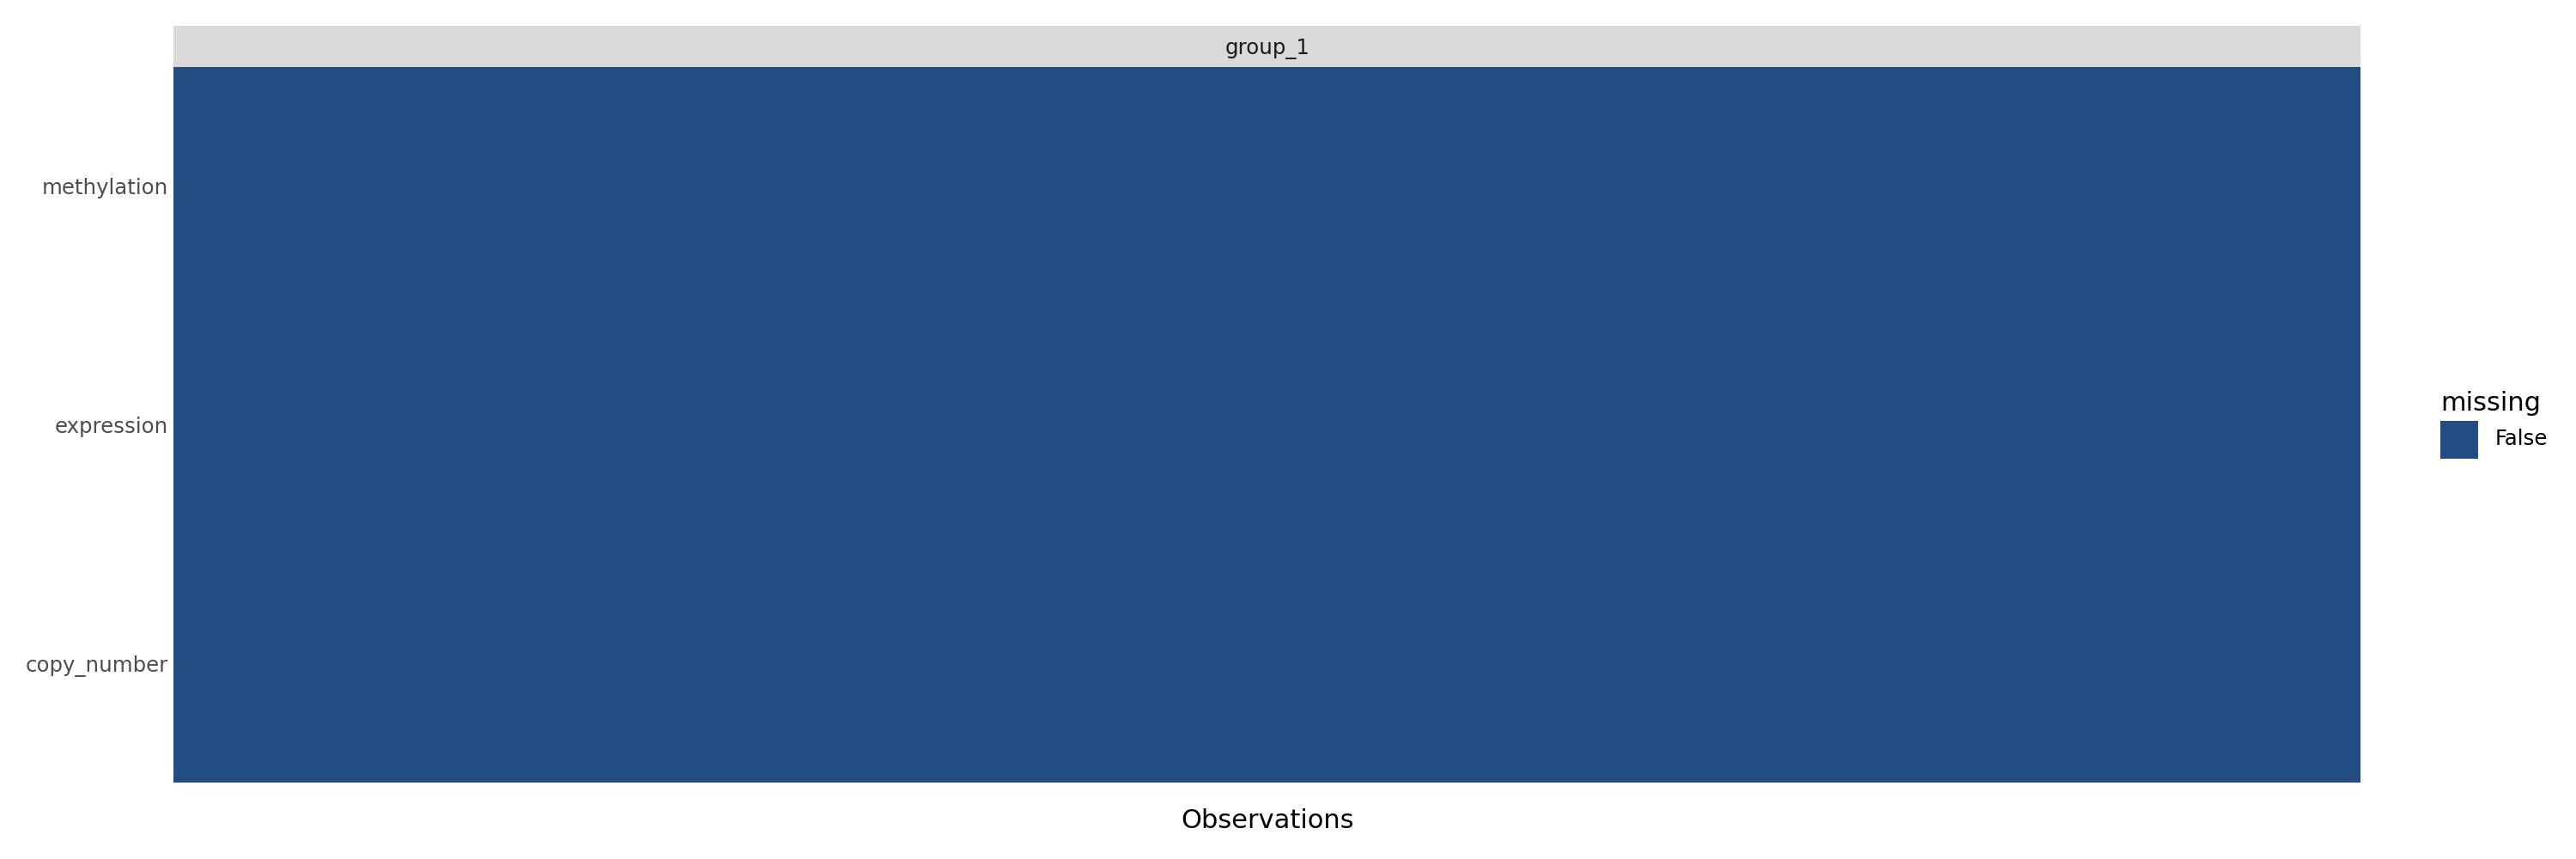

WARNING	Could not import dask. Data arrays may be copied, resulting in high memory usage.
INFO	Initializing factors using `random` method...


  0%|          | 0/10000 [00:00<?, ?epochs/s]

INFO	Training converged after 7233 epochs.


Extracting MOFA factors...
Train factors: (164, 15), Test factors: (41, 15)
Training ML classifiers...

Top 5 models:
              Model  Accuracy  F1 (Macro)
      Random Forest  0.682927    0.498611
Logistic Regression  0.682927    0.495398
       SVM (Linear)  0.682927    0.502484
K-Nearest Neighbors  0.658537    0.476698
            XGBoost  0.560976    0.365272

EXPERIMENT: TOP 4000 FEATURES
Expression: 4000 features
Methylation: 4000 features
Copy Number: 4000 features

Training MOFA model...


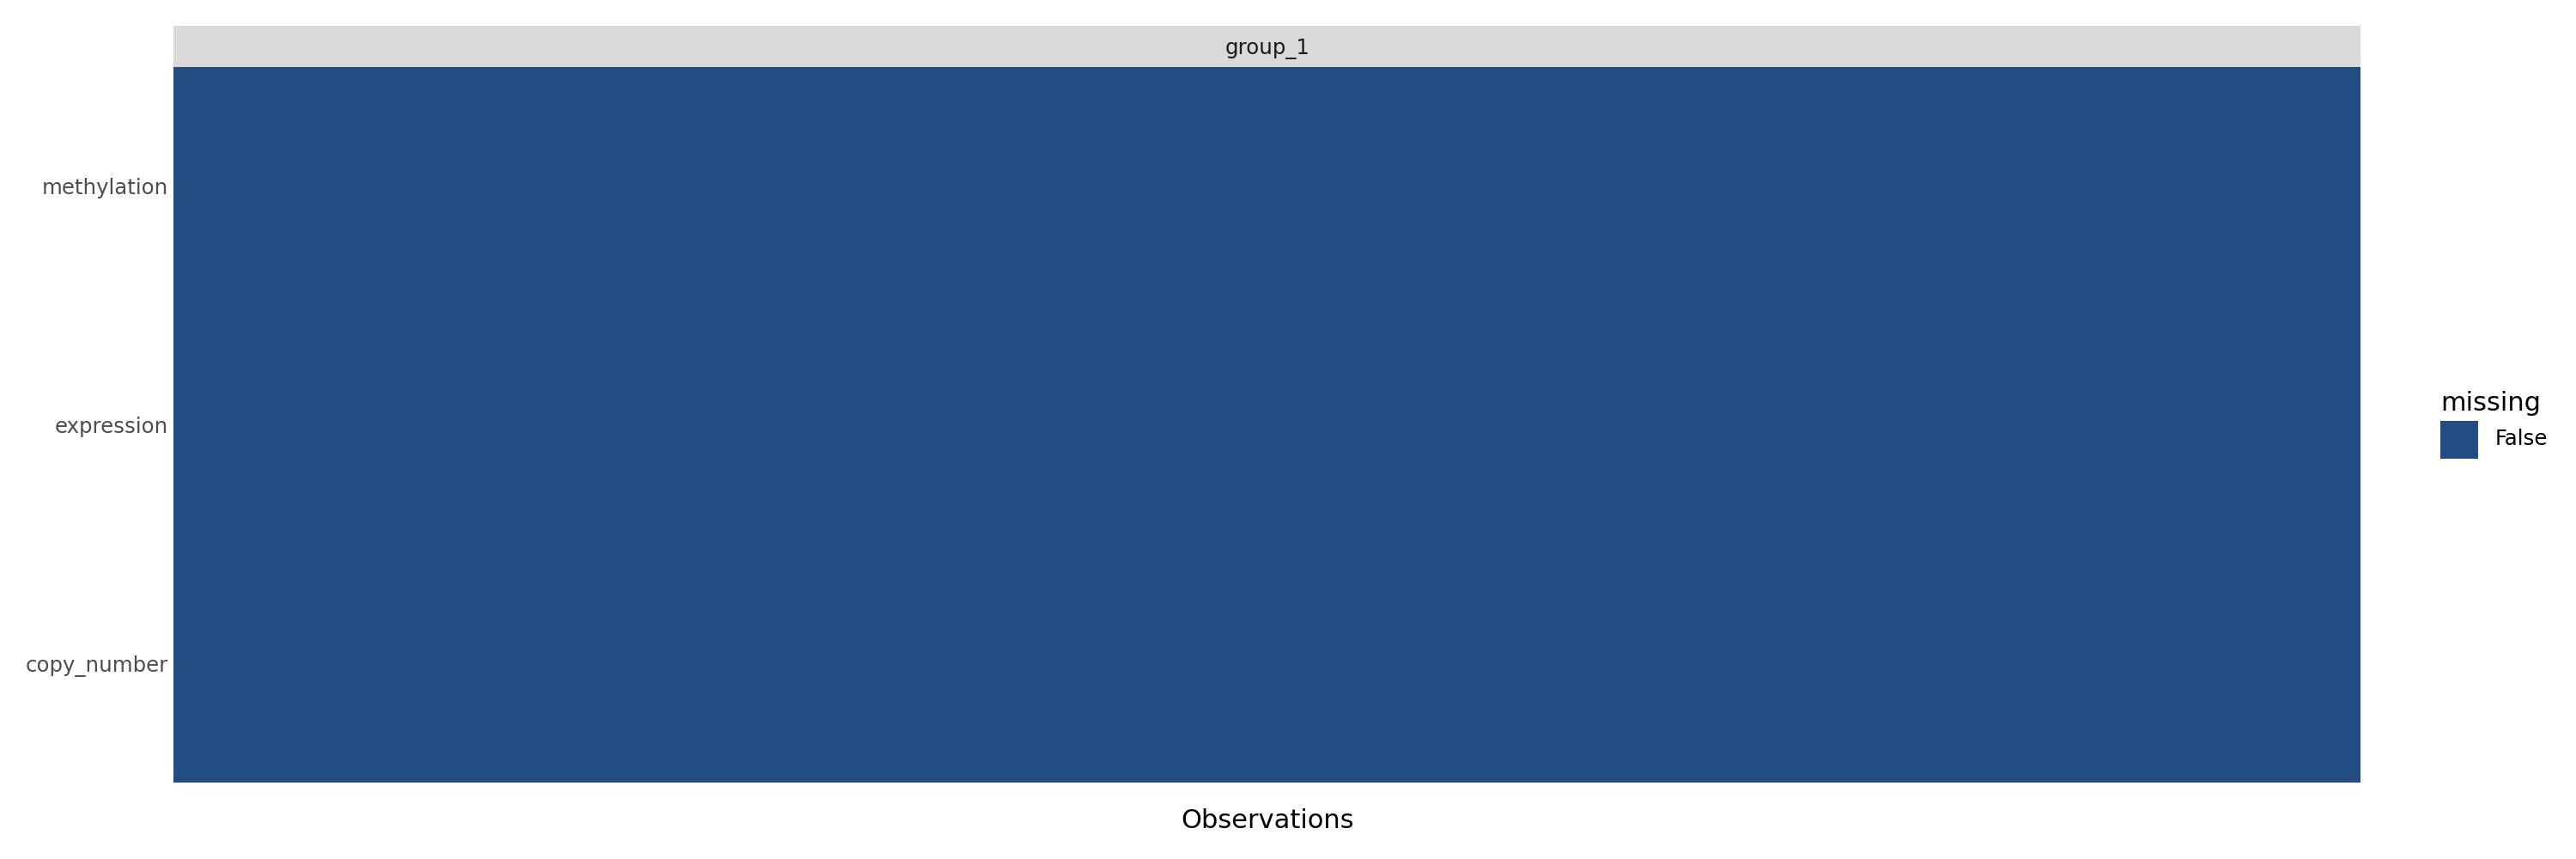

INFO	Initializing factors using `random` method...


  0%|          | 0/10000 [00:00<?, ?epochs/s]

INFO	Training converged after 6064 epochs.


Extracting MOFA factors...
Train factors: (164, 15), Test factors: (41, 15)
Training ML classifiers...

Top 5 models:
              Model  Accuracy  F1 (Macro)
K-Nearest Neighbors  0.731707    0.595801
      Random Forest  0.707317    0.526858
Logistic Regression  0.682927    0.495398
       SVM (Linear)  0.682927    0.489884
            XGBoost  0.634146    0.466216

EXPERIMENT: TOP 6000 FEATURES
Expression: 6000 features
Methylation: 6000 features
Copy Number: 6000 features

Training MOFA model...


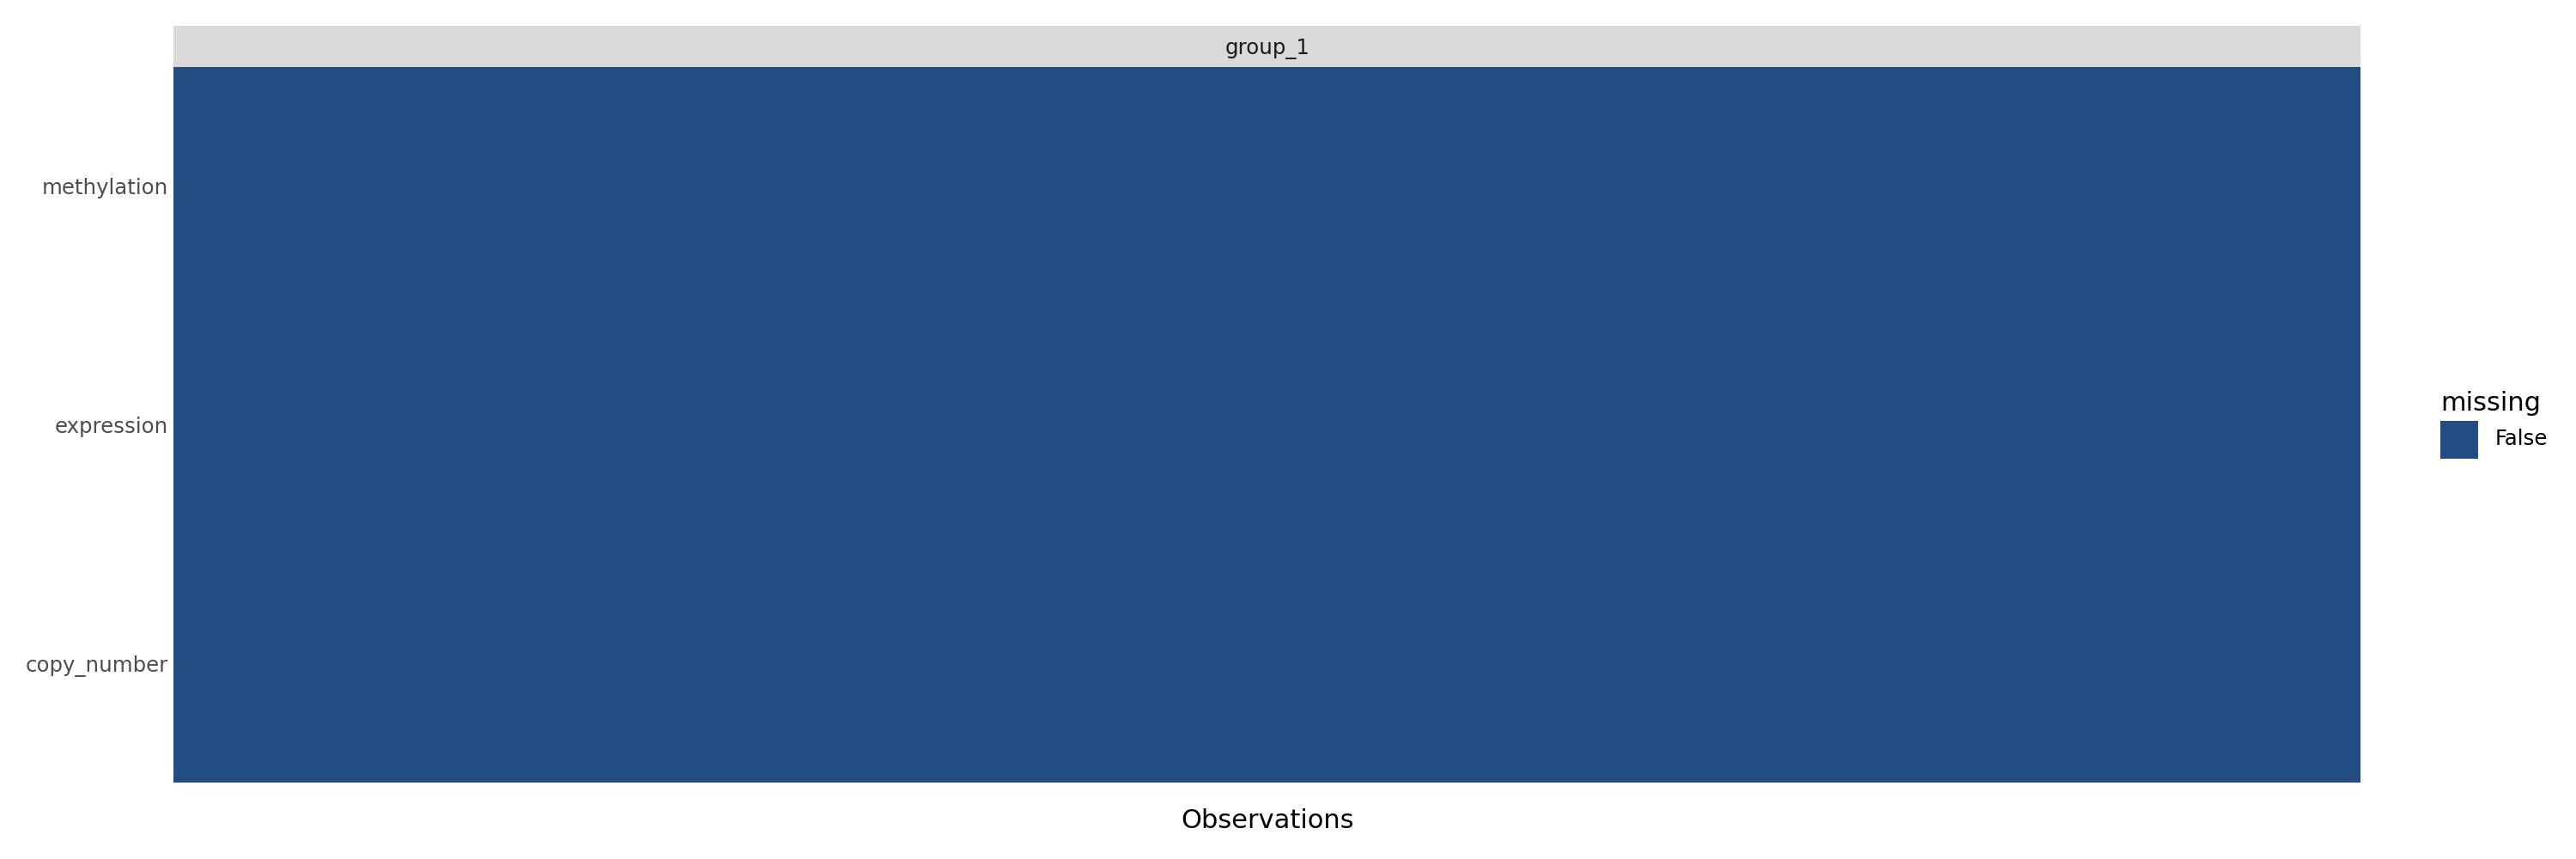

INFO	Initializing factors using `random` method...


  0%|          | 0/10000 [00:00<?, ?epochs/s]

INFO	Training converged after 4728 epochs.


Extracting MOFA factors...
Train factors: (164, 15), Test factors: (41, 15)
Training ML classifiers...

Top 5 models:
              Model  Accuracy  F1 (Macro)
K-Nearest Neighbors  0.731707    0.548203
      Random Forest  0.707317    0.526389
            XGBoost  0.682927    0.499869
       SVM (Linear)  0.658537    0.492043
Logistic Regression  0.634146    0.469057

EXPERIMENT: TOP 10000 FEATURES
Expression: 10000 features
Methylation: 10000 features
Copy Number: 10000 features

Training MOFA model...


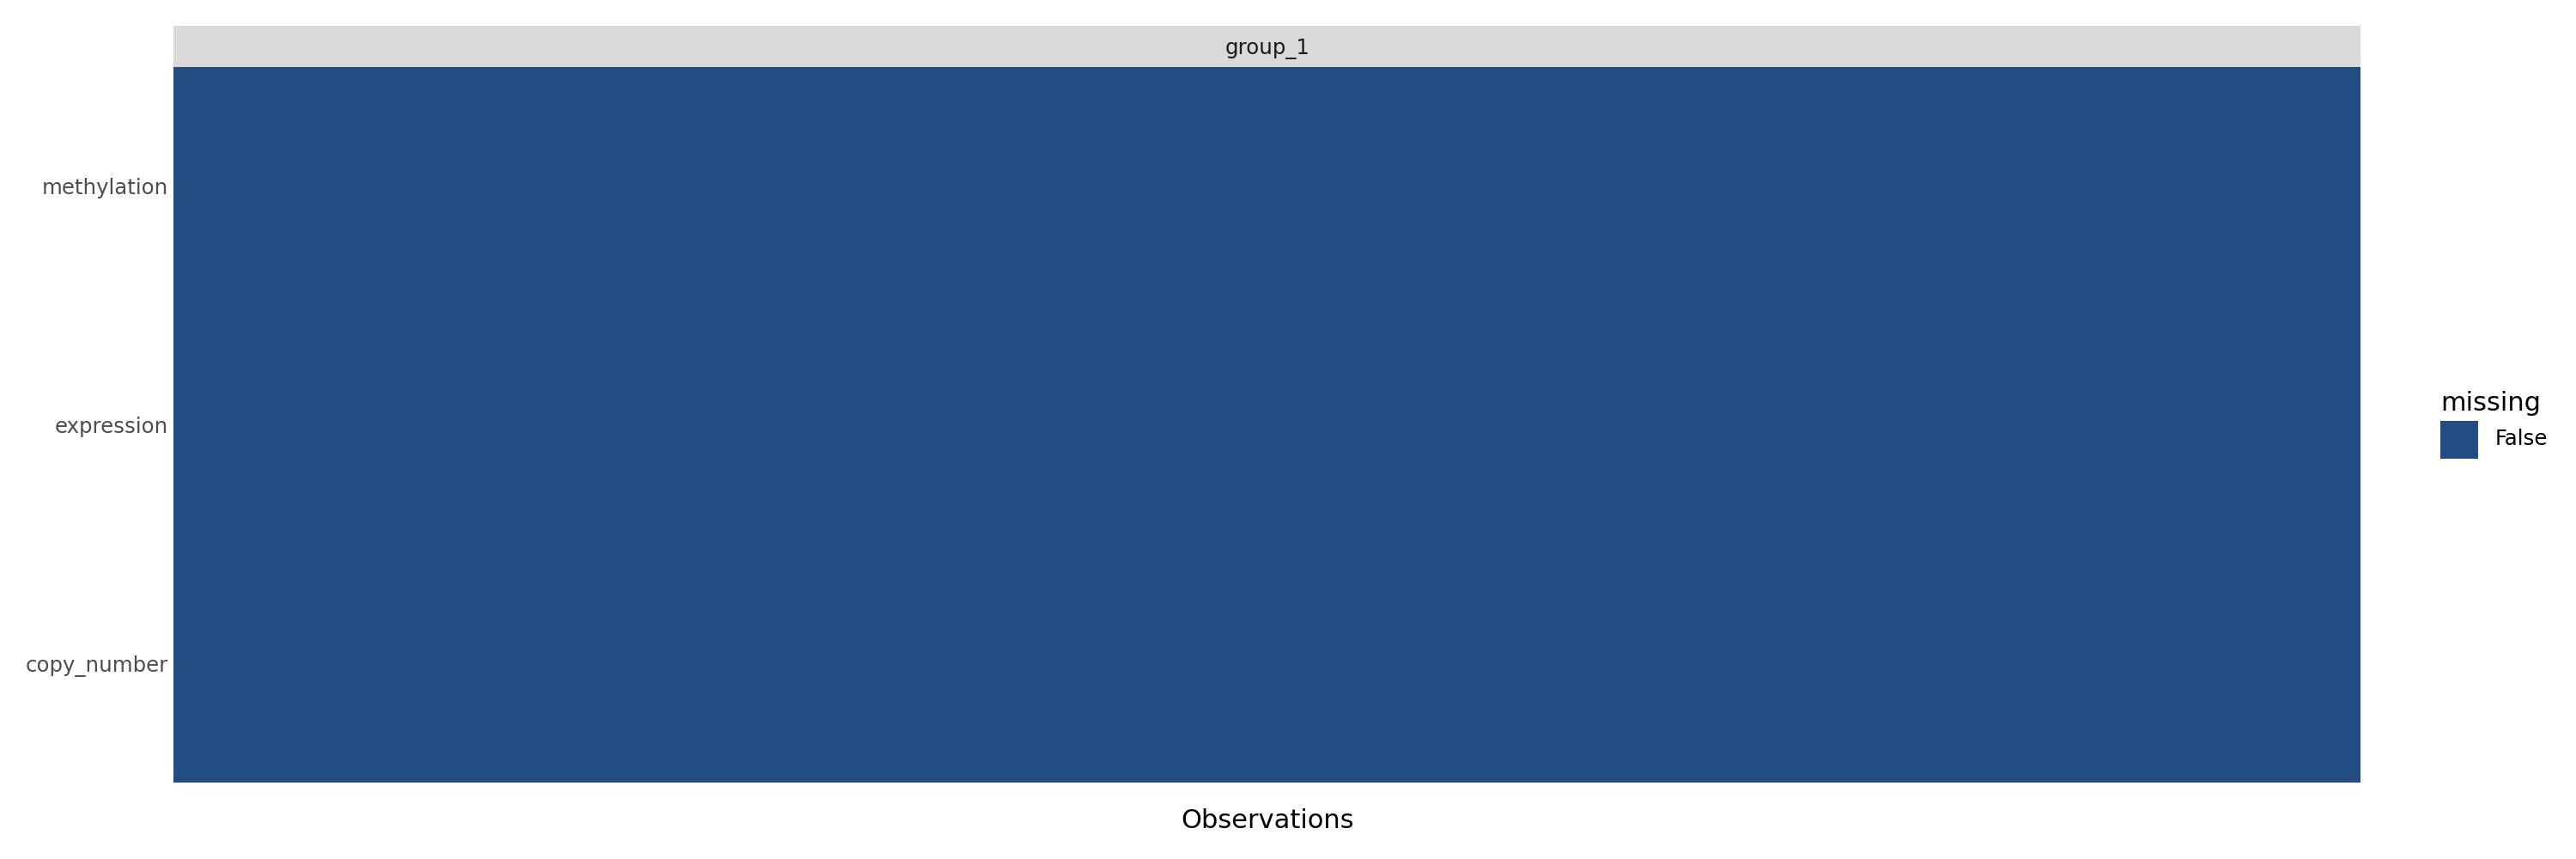

INFO	Initializing factors using `random` method...


  0%|          | 0/10000 [00:00<?, ?epochs/s]

INFO	Training converged after 4653 epochs.


Extracting MOFA factors...
Train factors: (164, 15), Test factors: (41, 15)
Training ML classifiers...

Top 5 models:
              Model  Accuracy  F1 (Macro)
K-Nearest Neighbors  0.756098    0.651154
       SVM (Linear)  0.707317    0.582586
Logistic Regression  0.682927    0.545797
            XGBoost  0.658537    0.473684
      Random Forest  0.609756    0.509055


In [13]:
print("=" * 80)
print("RUNNING FEATURE COUNT COMPARISON EXPERIMENTS")
print("=" * 80)

all_results = []
all_classifiers = {}
all_models = {}
all_embeddings = {}

for n_features in FEATURE_COUNTS:
    results_df, ml_clf, mofa_model, embeddings_df = run_experiment(
        n_features, y_train, y_test, train_samples, test_samples
    )
    all_results.append(results_df)
    all_classifiers[n_features] = ml_clf
    all_models[n_features] = mofa_model
    all_embeddings[n_features] = embeddings_df

combined_results = pd.concat(all_results, ignore_index=True)

In [14]:
print("=" * 80)
print("SIDE-BY-SIDE COMPARISON")
print("=" * 80)

comparison_summary = []
for n_features in FEATURE_COUNTS:
    subset = combined_results[combined_results['N_Features'] == n_features]
    best_row = subset.loc[subset['Accuracy'].idxmax()]
    comparison_summary.append({
        'N_Features': n_features,
        'Best_Model': best_row['Model'],
        'Accuracy': best_row['Accuracy'],
        'F1_Macro': best_row['F1 (Macro)'],
        'C_Index': best_row['C-Index']
    })

comparison_df = pd.DataFrame(comparison_summary)
print("\nBest Model Performance by Feature Count:")
print(comparison_df.to_string(index=False))

# Pivot tables
pivot_accuracy = combined_results.pivot_table(
    values='Accuracy', index='Model', columns='N_Features', aggfunc='first'
)
pivot_accuracy.columns = [f'{c}_features' for c in pivot_accuracy.columns]
pivot_accuracy = pivot_accuracy.sort_values(f'{FEATURE_COUNTS[-1]}_features', ascending=False)

print("\nAccuracy by Model and Feature Count:")
print(pivot_accuracy.head(10).to_string())

SIDE-BY-SIDE COMPARISON

Best Model Performance by Feature Count:
 N_Features          Best_Model  Accuracy  F1_Macro  C_Index
       2000       Random Forest  0.682927  0.498611 0.841580
       4000 K-Nearest Neighbors  0.731707  0.595801 0.824398
       6000 K-Nearest Neighbors  0.731707  0.548203 0.779110
      10000 K-Nearest Neighbors  0.756098  0.651154 0.850149

Accuracy by Model and Feature Count:
                     2000_features  4000_features  6000_features  10000_features
Model                                                                           
K-Nearest Neighbors       0.658537       0.731707       0.731707        0.756098
SVM (Linear)              0.682927       0.682927       0.658537        0.707317
Logistic Regression       0.682927       0.682927       0.634146        0.682927
XGBoost                   0.560976       0.634146       0.682927        0.658537
Random Forest             0.682927       0.707317       0.707317        0.609756
Gradient Boosting       

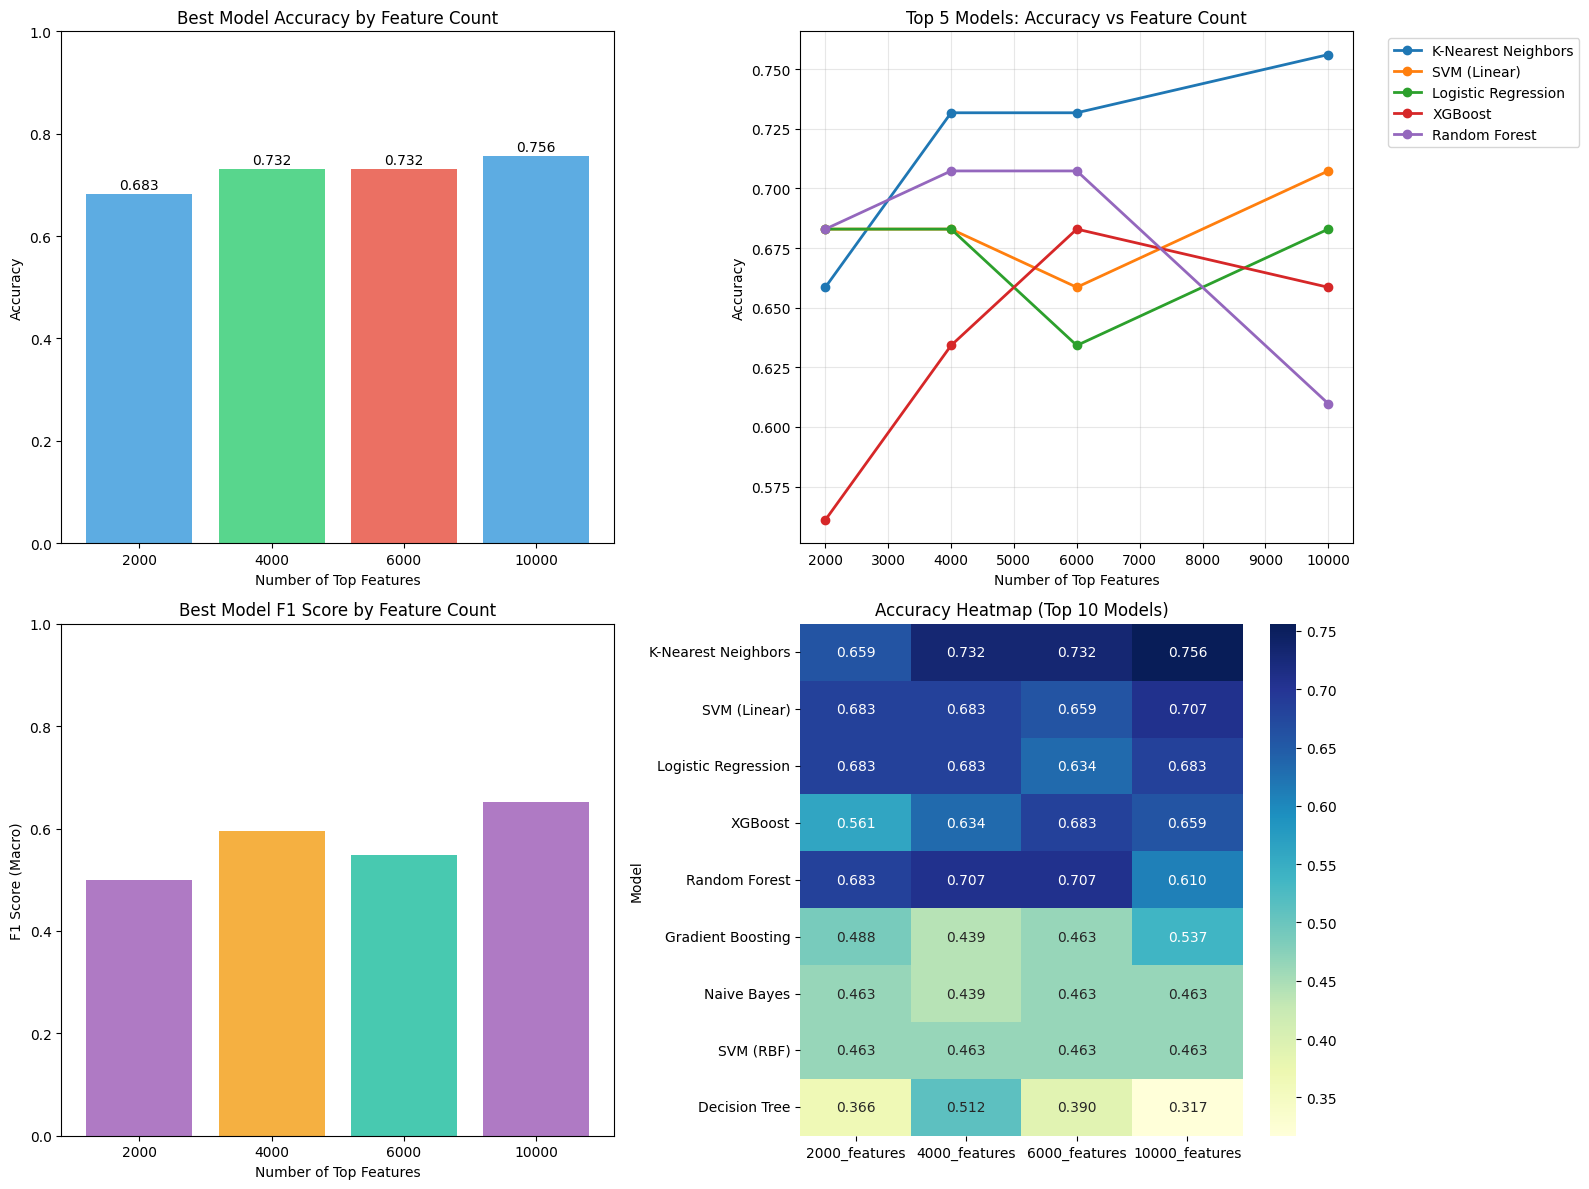

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Bar chart - Best accuracy
ax1 = axes[0, 0]
x_pos = np.arange(len(FEATURE_COUNTS))
accuracies = [comparison_df.loc[comparison_df['N_Features'] == n, 'Accuracy'].values[0] for n in FEATURE_COUNTS]
bars = ax1.bar(x_pos, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{n}' for n in FEATURE_COUNTS])
ax1.set_xlabel('Number of Top Features')
ax1.set_ylabel('Accuracy')
ax1.set_title('Best Model Accuracy by Feature Count')
ax1.set_ylim([0, 1])
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{acc:.3f}', ha='center')

# Line plot - Top models
ax2 = axes[0, 1]
for model in pivot_accuracy.index[:5]:
    values = [pivot_accuracy.loc[model, f'{n}_features'] for n in FEATURE_COUNTS]
    ax2.plot(FEATURE_COUNTS, values, marker='o', label=model, linewidth=2)
ax2.set_xlabel('Number of Top Features')
ax2.set_ylabel('Accuracy')
ax2.set_title('Top 5 Models: Accuracy vs Feature Count')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# F1 Score comparison
ax3 = axes[1, 0]
f1_scores = [comparison_df.loc[comparison_df['N_Features'] == n, 'F1_Macro'].values[0] for n in FEATURE_COUNTS]
bars = ax3.bar(x_pos, f1_scores, color=['#9b59b6', '#f39c12', '#1abc9c'], alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'{n}' for n in FEATURE_COUNTS])
ax3.set_xlabel('Number of Top Features')
ax3.set_ylabel('F1 Score (Macro)')
ax3.set_title('Best Model F1 Score by Feature Count')
ax3.set_ylim([0, 1])

# Heatmap
ax4 = axes[1, 1]
heatmap_data = pivot_accuracy.iloc[:10]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax4)
ax4.set_title('Accuracy Heatmap (Top 10 Models)')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/feature_comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()

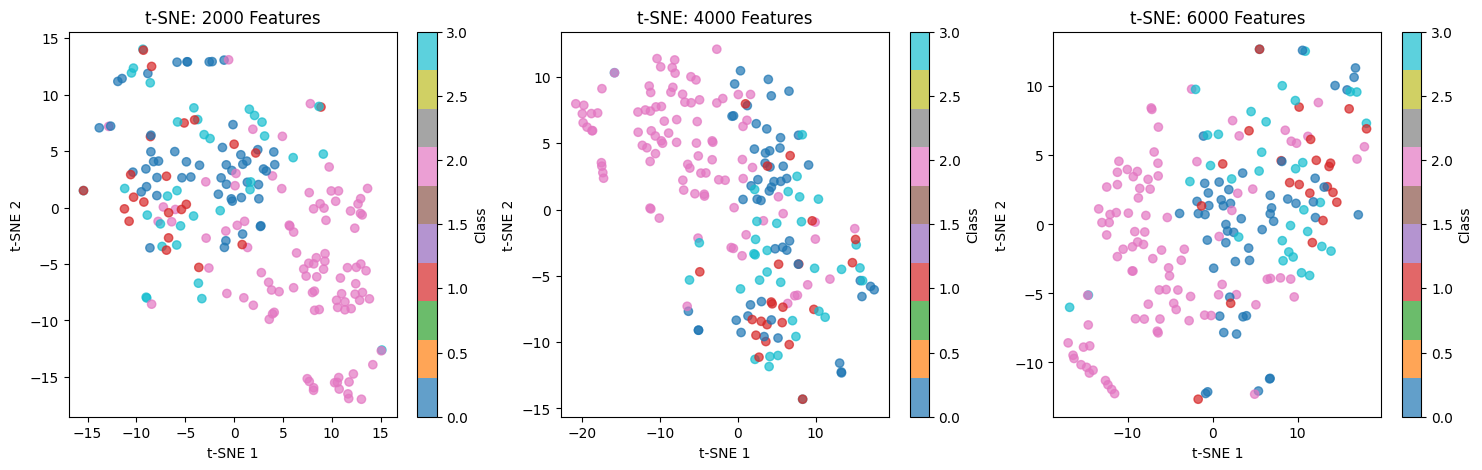

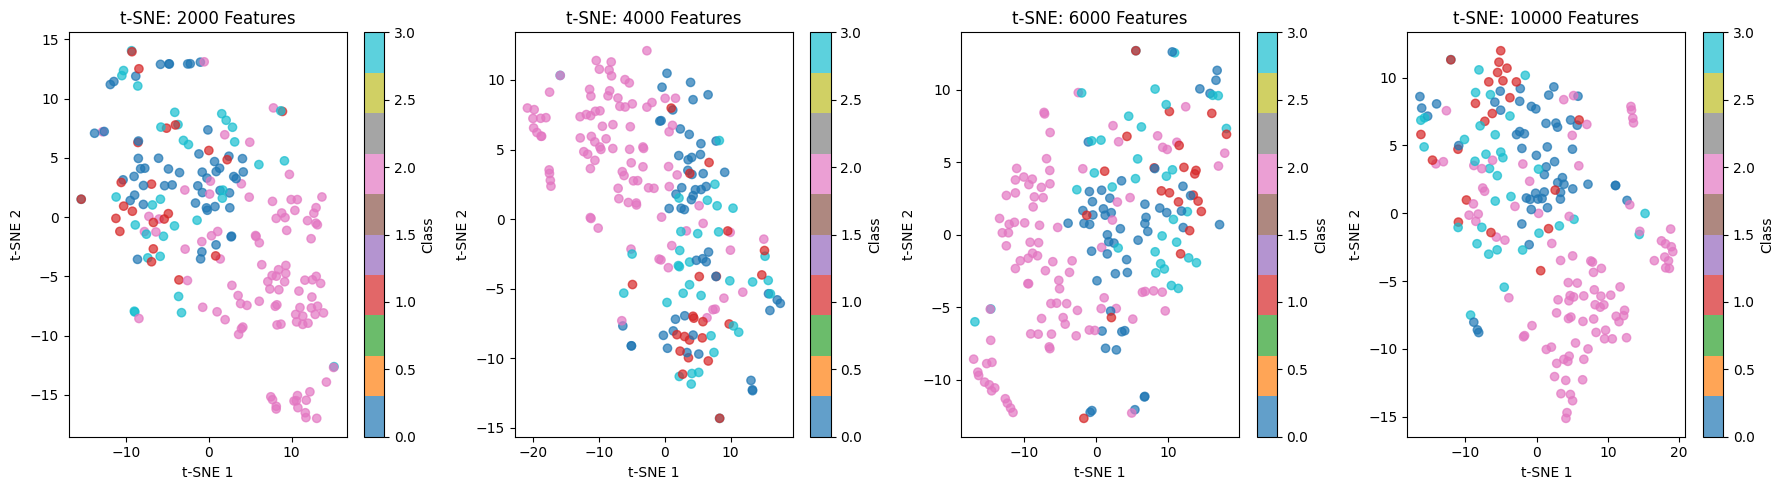

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for idx, n_features in enumerate(FEATURE_COUNTS):
    ax = axes[idx]
    embeddings = all_embeddings[n_features]
    
    factor_cols = [c for c in embeddings.columns if c.startswith('Factor_')]
    X_embed = embeddings[factor_cols].values
    labels = embeddings['Label'].values
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_embed)-1))
    X_2d = tsne.fit_transform(X_embed)
    
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    ax.set_title(f't-SNE: {n_features} Features')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=ax, label='Class')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/tsne_embeddings_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import logrank_test, multivariate_logrank_test
    print("Lifelines library loaded successfully!")
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lifelines"])
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import logrank_test, multivariate_logrank_test
    print("Lifelines installed and loaded!")
if HAS_SURVIVAL_DATA:
    print("=" * 80)
    print("PREPARING SURVIVAL DATA WITH MOFA FACTORS")
    print("=" * 80)
    
    # Use the best performing feature count
    best_n = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'N_Features']
    print(f"Using embeddings from {best_n} features (best accuracy)")
    
    best_embeddings = all_embeddings[best_n]
    factor_cols = [c for c in best_embeddings.columns if c.startswith('Factor_')]
    
    # Merge with survival data
    survival_factors = best_embeddings[factor_cols].copy()
    survival_factors = survival_factors.join(survival_data[['time', 'event']], how='inner')
    survival_factors['label'] = best_embeddings.loc[survival_factors.index, 'Label']
    
    # Add subtype names
    survival_factors['subtype'] = survival_factors['label'].apply(
        lambda x: label_encoder.classes_[int(x)]
    )
    
    print(f"Samples with survival data: {len(survival_factors)}")
    print(f"Events: {survival_factors['event'].sum()}")
    print(f"Censored: {(survival_factors['event'] == 0).sum()}")
else:
    print("Survival data not available!")

Lifelines library loaded successfully!
PREPARING SURVIVAL DATA WITH MOFA FACTORS
Using embeddings from 10000 features (best accuracy)
Samples with survival data: 203
Events: 79
Censored: 124


In [19]:
if HAS_SURVIVAL_DATA:
    print("=" * 80)
    print("RISK STRATIFICATION USING MOFA FACTORS")
    print("=" * 80)
    
    # Use first few factors to create risk score
    # Fit Cox model to find important factors
    cox_factors = survival_factors[['time', 'event'] + factor_cols[:5]].dropna()
    
    cph = CoxPHFitter()
    cph.fit(cox_factors, duration_col='time', event_col='event')
    
    print("\nCox Proportional Hazards - Factor Importance (first 5 factors):")
    print(cph.summary[['coef', 'exp(coef)', 'p', 'coef lower 95%', 'coef upper 95%']])
    
    # Create risk score
    risk_scores = cph.predict_partial_hazard(cox_factors)
    median_risk = risk_scores.median()
    
    survival_factors_cox = survival_factors.loc[cox_factors.index].copy()
    survival_factors_cox['risk_score'] = risk_scores
    survival_factors_cox['risk_group'] = (risk_scores > median_risk).astype(int)
    survival_factors_cox['risk_group'] = survival_factors_cox['risk_group'].map({0: 'Low Risk', 1: 'High Risk'})
    
    print(f"\nRisk group distribution:")
    print(survival_factors_cox['risk_group'].value_counts())

RISK STRATIFICATION USING MOFA FACTORS

Cox Proportional Hazards - Factor Importance (first 5 factors):
               coef  exp(coef)         p  coef lower 95%  coef upper 95%
covariate                                                               
Factor_1   0.000307   1.000307  0.694112       -0.001224        0.001839
Factor_2  -0.000643   0.999357  0.277506       -0.001803        0.000517
Factor_3   0.000070   1.000070  0.857264       -0.000693        0.000832
Factor_4   0.000587   1.000587  0.563516       -0.001405        0.002579
Factor_5  -0.000281   0.999719  0.780014       -0.002254        0.001692

Risk group distribution:
risk_group
Low Risk     102
High Risk    101
Name: count, dtype: int64


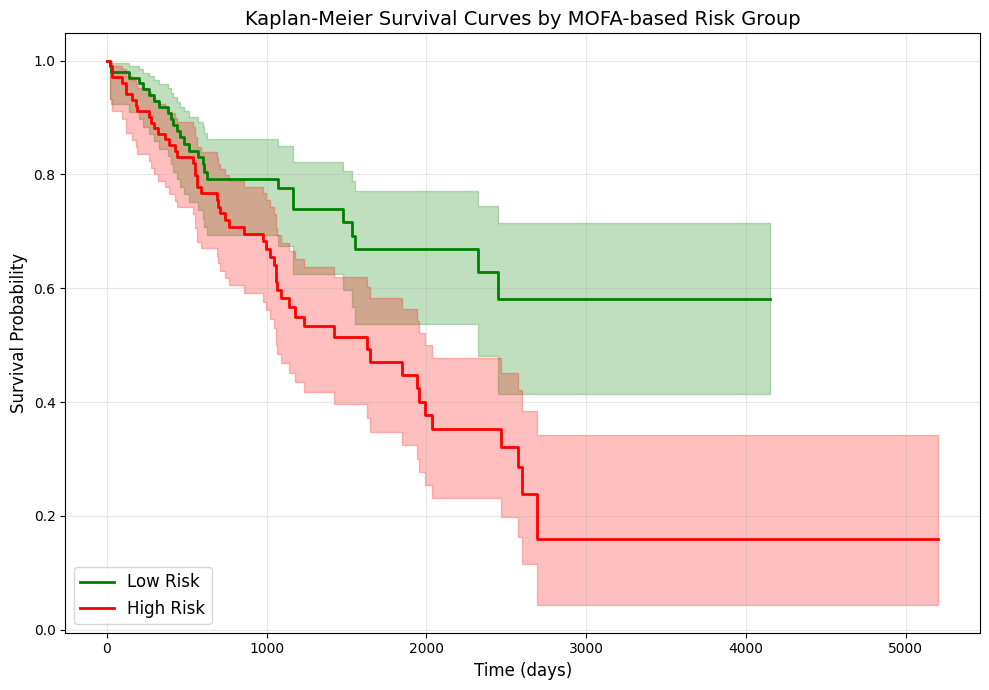


Log-rank test (Low Risk vs High Risk):
  Test statistic: 9.9564
  p-value: 1.6029e-03
  SIGNIFICANT difference between risk groups!


In [20]:
if HAS_SURVIVAL_DATA:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    kmf = KaplanMeierFitter()
    
    # Low risk
    mask_low = survival_factors_cox['risk_group'] == 'Low Risk'
    kmf.fit(
        survival_factors_cox.loc[mask_low, 'time'],
        event_observed=survival_factors_cox.loc[mask_low, 'event'],
        label='Low Risk'
    )
    kmf.plot_survival_function(ax=ax, color='green', linewidth=2)
    
    # High risk
    mask_high = survival_factors_cox['risk_group'] == 'High Risk'
    kmf.fit(
        survival_factors_cox.loc[mask_high, 'time'],
        event_observed=survival_factors_cox.loc[mask_high, 'event'],
        label='High Risk'
    )
    kmf.plot_survival_function(ax=ax, color='red', linewidth=2)
    
    ax.set_xlabel('Time (days)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title('Kaplan-Meier Survival Curves by MOFA-based Risk Group', fontsize=14)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/kaplan_meier_by_risk_group.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Log-rank test
    print("\nLog-rank test (Low Risk vs High Risk):")
    results = logrank_test(
        survival_factors_cox.loc[mask_low, 'time'],
        survival_factors_cox.loc[mask_high, 'time'],
        survival_factors_cox.loc[mask_low, 'event'],
        survival_factors_cox.loc[mask_high, 'event']
    )
    print(f"  Test statistic: {results.test_statistic:.4f}")
    print(f"  p-value: {results.p_value:.4e}")
    if results.p_value < 0.05:
        print("  SIGNIFICANT difference between risk groups!")
    else:
        print("  No significant difference between risk groups")

In [21]:
if HAS_SURVIVAL_DATA:
    print("=" * 80)
    print("FULL COX PROPORTIONAL HAZARDS MODEL")
    print("=" * 80)
    
    # Use all factors
    all_factors_survival = survival_factors[['time', 'event'] + factor_cols].dropna()
    
    cph_full = CoxPHFitter(penalizer=0.1)  # Add regularization for stability
    cph_full.fit(all_factors_survival, duration_col='time', event_col='event')
    
    print("\nCox Model Summary:")
    print(cph_full.summary[['coef', 'exp(coef)', 'p']])
    
    # Concordance index
    c_index = cph_full.concordance_index_
    print(f"\nConcordance Index (C-index): {c_index:.4f}")
    if c_index > 0.7:
        print("  Good predictive performance!")
    elif c_index > 0.6:
        print("  Moderate predictive performance")
    else:
        print("  Weak predictive performance")
    
    # Significant factors
    sig_factors = cph_full.summary[cph_full.summary['p'] < 0.05]
    print(f"\nSignificant factors (p < 0.05): {len(sig_factors)}")
    if len(sig_factors) > 0:
        print(sig_factors[['coef', 'exp(coef)', 'p']])

FULL COX PROPORTIONAL HAZARDS MODEL

Cox Model Summary:
               coef  exp(coef)         p
covariate                               
Factor_1   0.000198   1.000199  0.667341
Factor_2  -0.000390   0.999610  0.524035
Factor_3   0.000213   1.000213  0.672616
Factor_4   0.000193   1.000193  0.777264
Factor_5  -0.000065   0.999935  0.908523
Factor_6   0.000447   1.000447  0.217401
Factor_7   0.000277   1.000277  0.607219
Factor_8   0.000192   1.000192  0.542889
Factor_9  -0.000016   0.999984  0.970531
Factor_10  0.000174   1.000174  0.743769
Factor_11 -0.000196   0.999804  0.593567
Factor_12 -0.000416   0.999585  0.212924
Factor_13  0.000298   1.000298  0.535923
Factor_14  0.000160   1.000160  0.553741
Factor_15 -0.000131   0.999869  0.818000

Concordance Index (C-index): 0.6569
  Moderate predictive performance

Significant factors (p < 0.05): 0


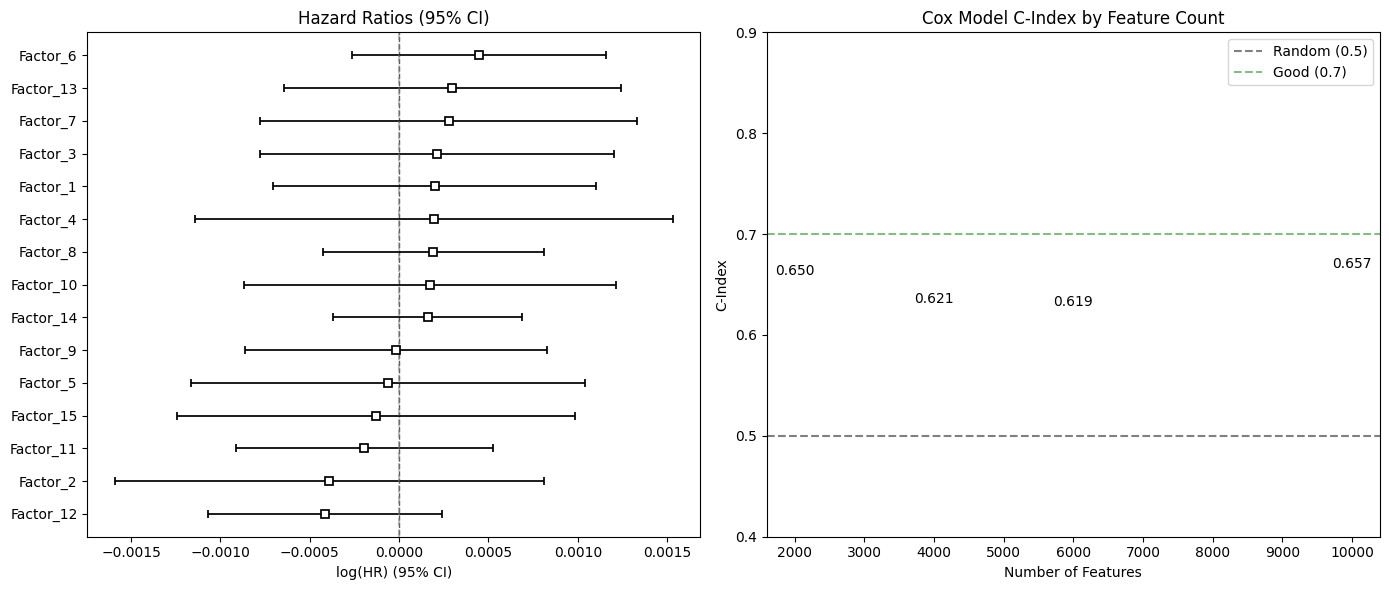

In [22]:
if HAS_SURVIVAL_DATA:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Hazard ratios
    ax1 = axes[0]
    cph_full.plot(ax=ax1)
    ax1.set_title('Hazard Ratios (95% CI)', fontsize=12)
    ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # C-index comparison across feature counts
    ax2 = axes[1]
    c_indices = []
    for n_features in FEATURE_COUNTS:
        emb = all_embeddings[n_features]
        factor_cols_temp = [c for c in emb.columns if c.startswith('Factor_')]
        
        surv_temp = emb[factor_cols_temp].join(survival_data[['time', 'event']], how='inner').dropna()
        if len(surv_temp) > 10:
            try:
                cph_temp = CoxPHFitter(penalizer=0.1)
                cph_temp.fit(surv_temp[['time', 'event'] + factor_cols_temp], 
                            duration_col='time', event_col='event')
                c_indices.append(cph_temp.concordance_index_)
            except:
                c_indices.append(np.nan)
        else:
            c_indices.append(np.nan)
    
    bars = ax2.bar(FEATURE_COUNTS, c_indices, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8)
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('C-Index')
    ax2.set_title('Cox Model C-Index by Feature Count')
    ax2.set_ylim([0.4, 0.9])
    ax2.axhline(y=0.5, color='gray', linestyle='--', label='Random (0.5)')
    ax2.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good (0.7)')
    for bar, ci in zip(bars, c_indices):
        if not np.isnan(ci):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{ci:.3f}', ha='center')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/cox_model_results.png', dpi=150, bbox_inches='tight')
    plt.show()

In [23]:
if HAS_SURVIVAL_DATA:
    print("=" * 80)
    print("SAVING SURVIVAL ANALYSIS RESULTS")
    print("=" * 80)
    
    # Save survival factors with risk groups
    survival_factors_cox.to_csv(f'{RESULTS_DIR}/survival_factors_with_risk.csv')
    print(f"Saved: survival_factors_with_risk.csv")
    
    # Save Cox model summary
    cox_summary = cph_full.summary.copy()
    cox_summary.to_csv(f'{RESULTS_DIR}/cox_model_summary.csv')
    print(f"Saved: cox_model_summary.csv")
    
    # Save survival analysis summary
    survival_summary = pd.DataFrame({
        'Metric': ['Total Samples', 'Events', 'Censored', 'Median Survival (days)',
                   'C-Index', 'Significant Factors', 'Log-rank p-value (subtypes)'],
        'Value': [
            len(survival_factors),
            survival_factors['event'].sum(),
            (survival_factors['event'] == 0).sum(),
            survival_factors['time'].median(),
            c_index,
            len(sig_factors) if len(sig_factors) > 0 else 0,
            results.p_value
        ]
    })
    survival_summary.to_csv(f'{RESULTS_DIR}/survival_analysis_summary.csv', index=False)
    print(f"Saved: survival_analysis_summary.csv")


SAVING SURVIVAL ANALYSIS RESULTS
Saved: survival_factors_with_risk.csv
Saved: cox_model_summary.csv
Saved: survival_analysis_summary.csv


In [24]:
print("=" * 80)
print("SAVING ALL RESULTS")
print("=" * 80)

comparison_df.to_csv(f'{RESULTS_DIR}/feature_comparison_summary.csv', index=False)
combined_results.to_csv(f'{RESULTS_DIR}/feature_comparison_all_results.csv', index=False)
pivot_accuracy.to_csv(f'{RESULTS_DIR}/accuracy_by_model_features.csv')

split_info = pd.DataFrame({
    'sample_id': train_samples + test_samples,
    'split': ['train'] * len(train_samples) + ['test'] * len(test_samples),
    'label': list(y_train) + list(y_test)
})
split_info.to_csv(f'{RESULTS_DIR}/train_test_split_info.csv', index=False)

label_mapping = pd.DataFrame({
    'encoded': list(range(len(label_encoder.classes_))),
    'subtype': label_encoder.classes_
})
label_mapping.to_csv(f'{RESULTS_DIR}/label_encoding_mapping.csv', index=False)

print("\nAll files saved!")

SAVING ALL RESULTS

All files saved!


In [25]:
print("=" * 80)
print("EXPERIMENT COMPLETED!")
print("=" * 80)

print(f"\nResults saved to: {os.path.abspath(RESULTS_DIR)}")

print("\nClassification Results:")
overall_best = combined_results.loc[combined_results['Accuracy'].idxmax()]
print(f"  Best Model: {overall_best['Model']}")
print(f"  Feature Count: {overall_best['N_Features']}")
print(f"  Accuracy: {overall_best['Accuracy']:.4f}")
print(f"  F1 (Macro): {overall_best['F1 (Macro)']:.4f}")

if HAS_SURVIVAL_DATA:
    print("\nSurvival Analysis Results:")
    print(f"  Samples analyzed: {len(survival_factors)}")
    print(f"  Cox C-Index: {c_index:.4f}")
    print(f"  Significant factors: {len(sig_factors) if len(sig_factors) > 0 else 0}")

print("\n Pipeline Features:")
print("  - No data leakage (train/test split before preprocessing)")
print("  - No SMOTE upsampling")
print(f"  - Compared {FEATURE_COUNTS} feature counts")
print("  - Survival analysis with Kaplan-Meier and Cox PH")

EXPERIMENT COMPLETED!

Results saved to: f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\src\Results_Mofaflex

Classification Results:
  Best Model: K-Nearest Neighbors
  Feature Count: 10000
  Accuracy: 0.7561
  F1 (Macro): 0.6512

Survival Analysis Results:
  Samples analyzed: 203
  Cox C-Index: 0.6569
  Significant factors: 0

 Pipeline Features:
  - No data leakage (train/test split before preprocessing)
  - No SMOTE upsampling
  - Compared [2000, 4000, 6000, 10000] feature counts
  - Survival analysis with Kaplan-Meier and Cox PH
